In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import subprocess as sp
import itertools as it

In [3]:
def genData(procs, sizes, data_file, cycles=20, clean=False):
    sp.run(
        "/usr/bin/mpiCC -O2 -o 15-poisson.o ./10-poisson.cpp -lblas -llapack",
        shell=True,
        stdout=sp.DEVNULL,
        stderr=sp.DEVNULL
    )
    if clean:
        sp.run(
            f'echo "num_sites total_time" > {data_file}',
            shell=True,
            stdout=sp.DEVNULL,
            stderr=sp.DEVNULL
        )

    for size, proc in it.product(sizes, procs):
        for _ in range(cycles):
            sp.run(
                f"/usr/bin/mpirun -n {proc} ./15-poisson.o 0 0 {size}",
                shell=True,
                stdout=sp.DEVNULL,
                stderr=sp.DEVNULL
            )
        print(f"Finished {size}x{size} with {proc} processes")
        
def plotModel(
    data: pd.DataFrame,
    xdata: str,
    ydata: str,
    plot: bool,
    loglog: bool
):
    x = data[xdata].values.reshape(-1, 1)
    y = data[ydata].values.reshape(-1, 1)
    xname = xdata
    yname = ydata
    if loglog:
        x = np.log10(x)
        y = np.log10(y)
        xname = "log(" + xdata + ")"
        yname = "log(" + ydata + ")"

    linear_model = LinearRegression()
    linear_model.fit(x, y)
    model = linear_model.predict(x)

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title("Model: y = {:.6f}x + {:.6f}".format(linear_model.coef_[0][0], linear_model.intercept_[0]), size=24)
        ax.set_xlabel(xname, size=20)
        ax.tick_params(axis='x', labelsize=16)
        ax.set_ylabel(yname, size=20)
        ax.tick_params(axis='y', labelsize=16)
        ax.scatter(x, y)
        ax.plot(x, model, color='red')
        plt.show()
    
    return linear_model

In [4]:
# Variables
# data_file = "/home/jared/Desktop/lp-timings.txt"
data_file = "./lp-timings.txt"
procs = np.array([1])
sizes = np.array([10, 50, 100, 200, 350, 500, 650, 800, 1000])

# Generate data if needed
# genData(procs=procs, sizes=sizes, cycles=5, data_file=data_file, clean=True)

# Load the data
data = pd.read_csv(data_file, delimiter=" ")

Finished 10x10 with 1 processes
Finished 50x50 with 1 processes
Finished 100x100 with 1 processes
Finished 200x200 with 1 processes
Finished 350x350 with 1 processes
Finished 500x500 with 1 processes
Finished 650x650 with 1 processes
Finished 800x800 with 1 processes
Finished 1000x1000 with 1 processes


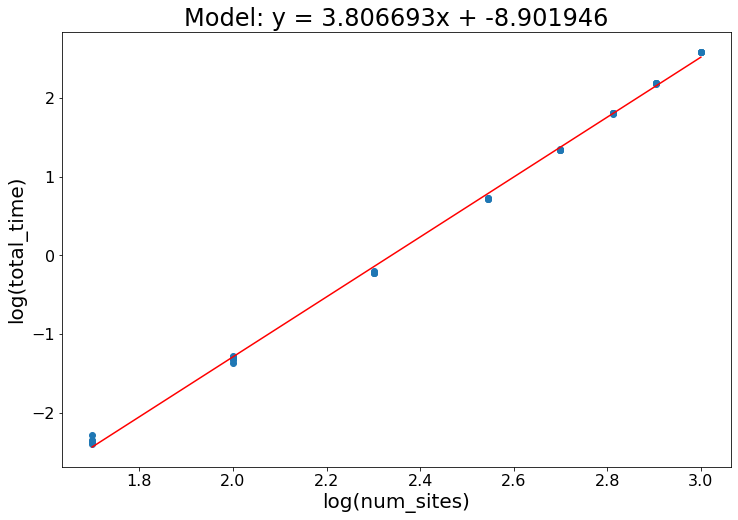

In [5]:
limit_row_data = data[data["num_sites"] > 10]
row_scaling_model = plotModel(limit_row_data, "num_sites", "total_time", plot=True, loglog=True)

In [10]:
def numSites(run_time: float, model: LinearRegression):
    return 10**((1/model.coef_[0][0]) * (np.log10(run_time) - model.intercept_[0]))
numSites(300, row_scaling_model)

975.498229094497

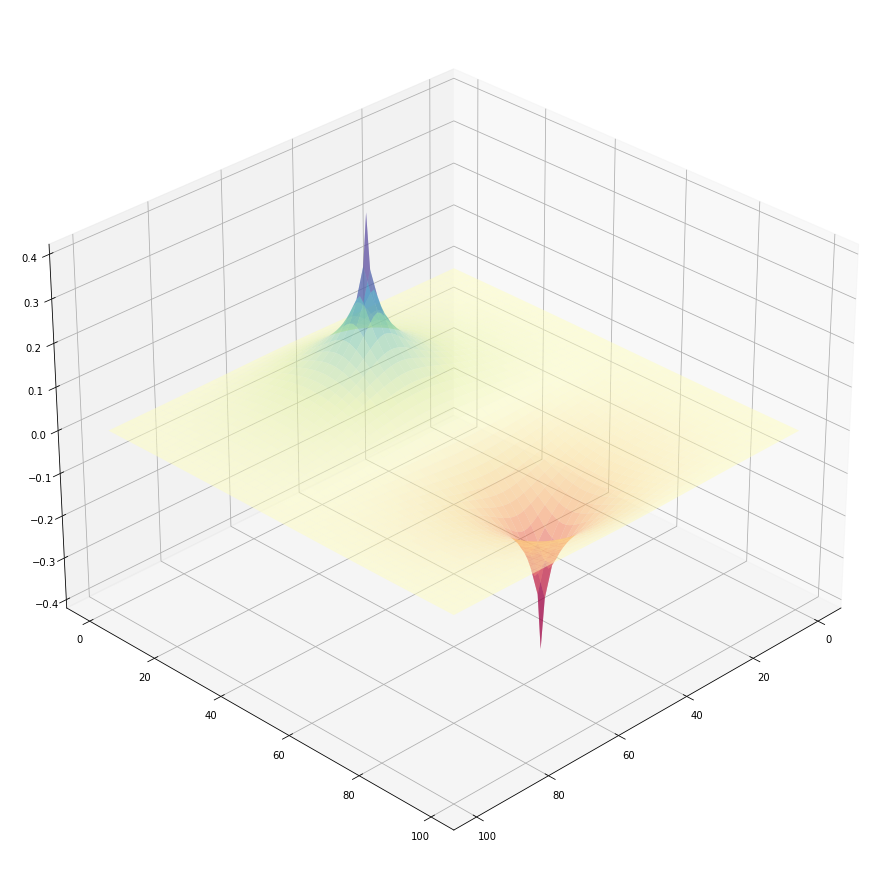

In [ ]:
solution = np.genfromtxt("lp-data.txt", dtype=np.float64)
x, y = np.meshgrid(range(solution.shape[0]), range(solution.shape[1]))

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(x, y, solution, alpha=0.5, cmap=plt.get_cmap("Spectral"))
ax.view_init(30, 45)

plt.show()

In [ ]:
import plotly.graph_objects as go

# Configure the trace.
plot = go.Surface(
    x=np.array(range(solution.shape[0])),
    y=np.array(range(solution.shape[1])),
    z=solution,
    # colorscale="Spectral",
    opacity=0.8,
    contours = {
        "x": {"show": True},
        "y": {"show": True},
        "z": {"show": True},
    }
)

# Configure the layout.
layout = go.Layout(
    margin={
        "l": 10, 
        "r": 10, 
        "b": 10, 
        "t": 10
    },
    scene={
        "xaxis": {"nticks": 20},
        "yaxis": {"nticks": 20},
        "zaxis": {"nticks": 20},
        #"backgroundcolor": "rgba(0, 0, 0, 0)"
    },
    width=1280,
    height=720,
    # plot_bgcolor="#23272E",
    # paper_bgcolor="#23272E",
    # font={
    #     "color": "rgba(255, 255, 255, 255)"
    # }
)

plot_figure = go.Figure(data=[plot], layout=layout)

# Render the plot.
plot_figure.show()